# Spark Experiment

## Set Seed

In [1]:
# Import findspark
import findspark
findspark.init('/home/ubuntu/spark-3.3.1-bin-hadoop3')
findspark.find()

'/home/ubuntu/spark-3.3.1-bin-hadoop3'

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from sklearn.neighbors import NearestNeighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator

In [3]:
SEED = 42

In [4]:
from pyspark.sql import SparkSession

# The entry point into all functionality in Spark is the SparkSession class.
spark = (SparkSession
	.builder
	.appName("DS5110/CS5501: my awesome Spark program")
	.master("spark://172.31.88.97:7077")
	.config("spark.executor.memory", "1024M")
	.getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/23 14:23:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

## Read Data

In [6]:
# Split data into X and y
X_reg_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_reg_train.csv')
              )
X_reg_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_reg_test.csv')
              )
X_class_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_class_train.csv')
              )
X_class_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/X_class_test.csv')
              )
y_reg_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_reg_train.csv')
              )
y_reg_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_reg_test.csv')
              )
y_class_train = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_class_train.csv')
              )
y_class_test = (spark.read
               .format('csv')
               .option('inferSchema', True)
               .option('header', True)
               .load('hdfs://172.31.88.97:9000/y_class_test.csv')
              )

## Inspect Data
We will need to join X and y for each step I believe. It looks like the data has an old index column we can join on.

In [8]:
X_reg_train.head(5)

[Row(_c0=28120237, dateDelta=0.5764591848038317, seatsRemaining=0.6878736440934151, totalTravelDistance=0.5335992043260079, durationSeconds=0.38985526700984063),
 Row(_c0=23324511, dateDelta=-1.4312694411428493, seatsRemaining=1.0779777898947491, totalTravelDistance=1.02154231351557, durationSeconds=0.805486775199166),
 Row(_c0=16627325, dateDelta=0.9898150783810896, seatsRemaining=1.0779777898947491, totalTravelDistance=-0.9088603520372959, durationSeconds=1.1056650866692344),
 Row(_c0=39011620, dateDelta=-1.0769643895051997, seatsRemaining=0.2977694982920811, totalTravelDistance=0.2462945025647573, durationSeconds=0.5514897424168005),
 Row(_c0=32887241, dateDelta=-0.6045576539883336, seatsRemaining=-1.652751230714589, totalTravelDistance=0.881451591169175, durationSeconds=1.6690766866592086)]

In [9]:
y_reg_train.head(5)

[Row(_c0=28120237, baseFare=0.3627135043459776),
 Row(_c0=23324511, baseFare=0.34768249106493015),
 Row(_c0=16627325, baseFare=0.7786792876541005),
 Row(_c0=39011620, baseFare=-0.9753699252646759),
 Row(_c0=32887241, baseFare=0.7034703466492904)]

In [10]:
X_reg_train.count()

16000000

In [11]:
y_reg_train.count()

16000000

In [14]:
X_reg_train.show(5)

+--------+-------------------+------------------+-------------------+-------------------+
|     _c0|          dateDelta|    seatsRemaining|totalTravelDistance|    durationSeconds|
+--------+-------------------+------------------+-------------------+-------------------+
|28120237| 0.5764591848038317|0.6878736440934151| 0.5335992043260079|0.38985526700984063|
|23324511|-1.4312694411428493|1.0779777898947491|   1.02154231351557|  0.805486775199166|
|16627325| 0.9898150783810896|1.0779777898947491|-0.9088603520372959| 1.1056650866692344|
|39011620|-1.0769643895051997|0.2977694982920811| 0.2462945025647573| 0.5514897424168005|
|32887241|-0.6045576539883336|-1.652751230714589|  0.881451591169175| 1.6690766866592086|
+--------+-------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [15]:
X_class_train.show(5)

+--------+-------------------+-------------------+------------------+-------------------+-------------------+
|     _c0|          dateDelta|           baseFare|    seatsRemaining|totalTravelDistance|    durationSeconds|
+--------+-------------------+-------------------+------------------+-------------------+-------------------+
|28120237| 0.5764591848038317| 0.3627135043459776|0.6878736440934151| 0.5335992043260079|0.38985526700984063|
|23324511|-1.4312694411428493|0.34768249106493015|1.0779777898947491|   1.02154231351557|  0.805486775199166|
|16627325| 0.9898150783810896| 0.7786792876541005|1.0779777898947491|-0.9088603520372959| 1.1056650866692344|
|39011620|-1.0769643895051997|-0.9753699252646759|0.2977694982920811| 0.2462945025647573| 0.5514897424168005|
|32887241|-0.6045576539883336| 0.7034703466492904|-1.652751230714589|  0.881451591169175| 1.6690766866592086|
+--------+-------------------+-------------------+------------------+-------------------+-------------------+
only showi

### Combine X and y for each dataset

In [7]:
reg_train = X_reg_train.join(y_reg_train, X_reg_train._c0 == y_reg_train._c0, "left").drop('_c0')

In [25]:
reg_train.count()

16000000

In [8]:
reg_test = X_reg_test.join(y_reg_test, X_reg_test._c0 == y_reg_test._c0, "left").drop('_c0')

In [29]:
reg_test.count()

4000000

In [9]:
class_train = X_class_train.join(y_class_train, X_class_train._c0 == y_class_train._c0, "left").drop('_c0')
class_test = X_class_test.join(y_class_test, X_class_test._c0 == y_class_test._c0, "left").drop('_c0')

In [36]:
class_train.head()

Row(dateDelta=1.8165268655356053, baseFare=-0.24369898845498525, seatsRemaining=1.0779777898947491, totalTravelDistance=-0.7010986875405237, durationSeconds=-0.60304222477577, destinationAirport='EWR')

## Spark Experiment Function

In [10]:
def spark_time_algorithm(subset_prop, algorithm_name, SEED=SEED):
    '''
    algorithm_name one of 'KNN', 'RF', 'KMEANS'
    '''
    if (algorithm_name == "KNN" or algorithm_name == "RF"):
        # Subset data
        reg_train_subset = reg_train.limit(int(reg_train.count() * subset_prop))
        reg_test_subset = reg_test.limit(int(reg_test.count() * subset_prop))
        # Check subset shape
        print(f'reg_train_subset shape {reg_train_subset.count()}')
        print(f'reg_test_subset shape {reg_test_subset.count()}')
        # Assemble vectors for model
        numericCols = ['dateDelta', 'seatsRemaining', 'totalTravelDistance', 'durationSeconds']
        assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
        train = assembler.transform(reg_train_subset)
        test = assembler.transform(reg_test_subset)
      
    elif (algorithm_name == "KMEANS"):
        class_train_subset = class_train.limit(int(class_train.count() * subset_prop))
        class_test_subset = class_test.limit(int(class_test.count() * subset_prop))
        print(f'class_train_subset shape {class_train_subset.count()}')
        print(f'class_test_subset shape {class_test_subset.count()}')
        # Assemble vectors for model
        numericCols = ['dateDelta', 'baseFare', 'seatsRemaining', 'totalTravelDistance', 'durationSeconds']
        assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
        train = assembler.transform(class_train_subset)
        test = assembler.transform(class_test_subset)
       
    start_time = time.time()
       
    if algorithm_name == "KNN":
        # Cache vectors
        train.cache()
        # Create kNN tree locally, and broadcast
        train_collected = train.collect()
        knnobj = NearestNeighbors(n_neighbors=5).fit(train_collected)
        bc_knnobj = sc.broadcast(knnobj)
        # Get neighbors for each point, distributedly
        results = train.map(lambda x: bc_knnobj.value.kneighbors(x))
        # Evaluate
        metric = knn_model.score(reg_test_subset[['dateDelta', 'seatsRemaining', 'totalTravelDistance', 'durationSeconds']],
                                 reg_test_subset[['baseFare']]) # metric is KNN accuracy
                       
    elif algorithm_name == "KMEANS":
        # Trains a k-means model.
        kmeans = KMeans().setK(2).setSeed(1)
        model = kmeans.fit(train)
        # Make predictions
        predictions = model.transform(test)
        metric = None # No performance metric for KMEANS (unsupervised)
           
    elif algorithm_name == "RF":
        # Fit
        rf = RandomForestRegressor(featuresCol = 'features', labelCol='baseFare')
        model = rf.fit(train)
        # Predict
        predictions = model.transform(test)
        # Evaluate
        evaluator = RegressionEvaluator(
            labelCol='baseFare', predictionCol='prediction', metricName='rmse'
        )
        metric = evaluator.evaluate(predictions)
           
    end_time = time.time()
    time_delta = end_time - start_time
    return time_delta, metric

## Set proportions to loop over

In [11]:
props = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## KNN Test

In [ ]:
knn_times = []
knn_metrics = []

for prop in props:
    print(prop)
    runtime, metric = spark_time_algorithm(prop, algorithm_name="KNN")
    knn_times.append(runtime)
    knn_metrics.append(metric)
   
print(knn_times)
print(knn_metrics)

0.1


reg_train_subset shape 1600000


reg_test_subset shape 400000


In [ ]:
knn_frame = pd.DataFrame(list(zip(knn_times, knn_metrics)), columns=['Time', 'Metric'], index=props)
knn_frame.head()

In [ ]:
plt.scatter(x=knn_frame.index, y=knn_frame['Time'])
plt.title('KNN Spark Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [ ]:
knn_frame.to_csv('spark_knn_results.csv', index=True)

## KMeans Test

In [28]:
kmeans_times = []
kmeans_metrics = []

for prop in props:
    print(prop)
    runtime, metric = spark_time_algorithm(prop, algorithm_name="KMEANS")
    kmeans_times.append(runtime)
    kmeans_metrics.append(metric)
   
print(kmeans_times)
print(kmeans_metrics)

0.1


class_train_subset shape 1600000


class_test_subset shape 400000


0.2


class_train_subset shape 3200000


class_test_subset shape 800000


0.3


class_train_subset shape 4800000


class_test_subset shape 1200000


0.4


class_train_subset shape 6400000


class_test_subset shape 1600000


0.5


class_train_subset shape 8000000


class_test_subset shape 2000000


0.6


class_train_subset shape 9600000


class_test_subset shape 2400000


0.7


class_train_subset shape 11200000


class_test_subset shape 2800000


0.8


class_train_subset shape 12800000


class_test_subset shape 3200000


0.9


class_train_subset shape 14400000


class_test_subset shape 3600000


1.0


class_train_subset shape 16000000


class_test_subset shape 4000000


[106.52712798118591, 203.0396454334259, 242.61319184303284, 312.76893496513367, 351.06963205337524, 371.5358839035034, 456.9247965812683, 452.4203007221222, 487.53648018836975, 540.4554026126862]
[None, None, None, None, None, None, None, None, None, None]


In [29]:
kmeans_frame = pd.DataFrame(list(zip(kmeans_times, kmeans_metrics)), columns=['Time', 'Metric'], index=props)
kmeans_frame.head()

,Time,Metric
0.1,106.527128,None
0.2,203.039645,None
0.3,242.613192,None
0.4,312.768935,None
0.5,351.069632,None


Text(0, 0.5, 'Time (s)')

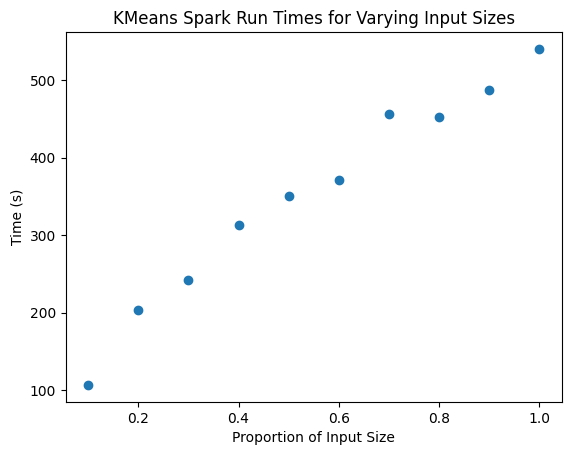

In [30]:
plt.scatter(x=kmeans_frame.index, y=kmeans_frame['Time'])
plt.title('KMeans Spark Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [32]:
kmeans_frame.to_csv('spark_kmeans_results.csv', index=True)

## Random Forest Test

In [53]:
rf_times = []
rf_metrics = []

for prop in props:
    print(prop)
    runtime, metric = spark_time_algorithm(prop, algorithm_name="RF")
    rf_times.append(runtime)
    rf_metrics.append(metric)
   
print(rf_times)
print(rf_metrics)

0.1


reg_train_subset shape 1600000


reg_test_subset shape 400000


0.2


reg_train_subset shape 3200000


reg_test_subset shape 800000


0.3


reg_train_subset shape 4800000


reg_test_subset shape 1200000


0.4


reg_train_subset shape 6400000


reg_test_subset shape 1600000


0.5


reg_train_subset shape 8000000


reg_test_subset shape 2000000


0.6


reg_train_subset shape 9600000


reg_test_subset shape 2400000


0.7


reg_train_subset shape 11200000


reg_test_subset shape 2800000


0.8


reg_train_subset shape 12800000


reg_test_subset shape 3200000


0.9


reg_train_subset shape 14400000


reg_test_subset shape 3600000


1.0


reg_train_subset shape 16000000


reg_test_subset shape 4000000


[78.02814388275146, 135.40745401382446, 183.21883511543274, 255.66787600517273, 279.17373967170715, 345.42775678634644, 441.09457516670227, 452.7518513202667, 495.7028157711029, 459.84275221824646]
[0.8051646144521695, 0.8028645235052145, 0.8093192336683939, 0.8015940596910148, 0.7986014847889866, 0.8016247153204518, 0.802847274899786, 0.802190069479265, 0.8008646971831581, 0.8009241539955444]


In [54]:
rf_frame = pd.DataFrame(list(zip(rf_times, rf_metrics)), columns=['Time', 'Metric'], index=props)
rf_frame.head()

,Time,Metric
0.1,78.028144,0.805165
0.2,135.407454,0.802865
0.3,183.218835,0.809319
0.4,255.667876,0.801594
0.5,279.173740,0.798601


Text(0, 0.5, 'Time (s)')

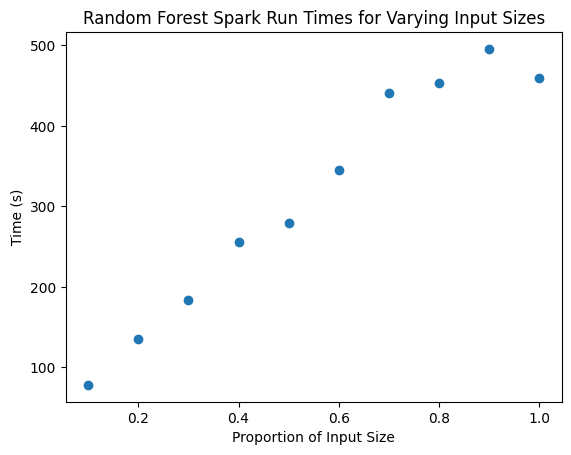

In [55]:
plt.scatter(x=rf_frame.index, y=rf_frame['Time'])
plt.title('Random Forest Spark Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [56]:
rf_frame.to_csv('spark_rf_results.csv', index=True)